In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
def process_data(trainfile, valfile):
    trainset = np.loadtxt(trainfile)
    valset = np.loadtxt(valfile)
    x = trainset.T[[0]]
    y = trainset.T[[1]]
    x_val = valset.T[[0]]
    y_val = valset.T[[1]]
    return x, y, x_val, y_val

In [5]:
x, y, x_val, y_val = process_data('sincTrain25.dt', 'sincValidate10.dt')

In [6]:
def softsign(a):
    return a/(1 + np.abs(a))

def softsign_deriv(a):
    return 1/(1 + np.abs(a)) ** 2

def mse(y, y_pred, m):
    return np.sum((y - y_pred) ** 2) / (2 * m)

In [7]:
class Layer(object):
    def __init__(self, input_dim, output_dim):
        xavier = (6 / (input_dim + output_dim)) ** 0.5
        self.W = np.random.uniform(-xavier, xavier, size=(output_dim, input_dim))
        self.b = np.zeros((output_dim, 1))
        self.A = None # input X
        self.Z = None # Z = WX, softsign(Z) = A_next
        self.dW = None
        self.db = None

    def forward(self, A):
        self.A = A.copy()
        self.Z = np.dot(self.W, A) + self.b
        A_next = softsign(self.Z)
        return A_next

    def backward(self, dA, m, dZ=None):
        if dZ is None:
            dZ = softsign_deriv(self.Z) * dA # slides 30
        self.dW = np.dot(dZ, self.A.T) / m # dW = delta * A, slides 28
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_last = np.dot(self.W.T, dZ)
        return dA_last, self.dW
    
    def update(self, learning_rate):
        # Gradient descent, slides 26
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

In [8]:
class NN(object):
    def __init__(self, x_dim, y_dim, num_neurons):
        self.layers = [] 
        num_neurons.insert(0, x_dim) # input layer 25
        num_neurons.append(y_dim) # output layer 25
        for i in range(1, len(num_neurons)):
            layer = Layer(num_neurons[i-1], num_neurons[i])
            self.layers.append(layer)

    def train(self, x, y, max_iteration = 100, learning_rate = 0.05):
        cost_train_after_each_epoch = []
        for i in range(max_iteration):
            output = self.__forward(A = x)
            cost_train = mse(output, y, x.shape[1])
            self.__backward(output, y, x.shape[1])
            self.__update(learning_rate = learning_rate)
            cost_train_after_each_epoch.append(cost_train)
        return cost_train_after_each_epoch
    
    def predict(self, x):
        y_pred = self.__forward(A = x)
        return y_pred

    def __forward(self, A): 
        for i in self.layers:
            A = i.forward(A)
        return A

    def __backward(self, A, y, m):  
        layer = self.layers[-1] # output layer
        dZ = A - y # delta = A - y, slides 29
        dA, dW = layer.backward(dA = None, m = m, dZ = dZ)
        norm = np.sum(dW ** 2) ** 0.5
        for i in self.layers[-2:: -1]: # except output layer
            dA, _ = i.backward(dA = dA, m = m, dZ = None)
        return norm

    def __update(self, learning_rate):
        for i in self.layers:
            i.update(learning_rate)

In [9]:
nnw = NN(x.shape[0],y.shape[0],[20])

In [ ]:
'''
max_iteration = 250000
x_axis = pd.DataFrame([i for i in range(1, max_iteration + 1)])
for i in (0.001, 0.01, 0.1, 0.5):
    cost_train, cost_pred, norm = nnw.train_and_pred(x, y, x_val, max_iteration, learning_rate = i)
    df = pd.concat([x_axis, cost_train, cost_pred, norm], axis = 1)
    df.columns = ['x_axis', 'cost_train','cost_pred', 'norm']
    plt.figure()
    ax = sns.lineplot(x = 'x_axis', y ='cost_train', data = df, label = 'Train ({learning_rate})'.format(learning_rate =i))
    ax = sns.lineplot(x = 'x_axis', y ='cost_pred', data = df, label = 'Val ({learning_rate})'.format(learning_rate =i))
    ax = sns.lineplot(x = 'x_axis', y ='norm', data = df, label = 'Grad Norm ({learning_rate})'.format(learning_rate =i))
    ax.lines[2].set_linestyle("--")
    ax.set_yscale("log", base=10)
    plt.legend(loc='best')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE / Grad Norm')
    #ax.set_yticklabels(['{:,.2f}'.format(x) + '%' for x in ax.get_yticks()]) # num to percentage
    ax.set_title('Learning_rate {learning_rate}'.format(learning_rate =i), fontsize=14, position=(0.5,1.05))
    plt.savefig('Assignment7_Question2_Plot{}.pdf'.format(i))
    plt.show()
'''

In [10]:
model = nnw.train(x, y, 120000, learning_rate = 0.1)

In [11]:
# plot function
points = np.array([np.arange(-15, 15.05, 0.05)])
y_pred = nnw.predict(points)

In [12]:
def sinc(x):
    return np.sin(x)/x

In [13]:
sinc = sinc(points)

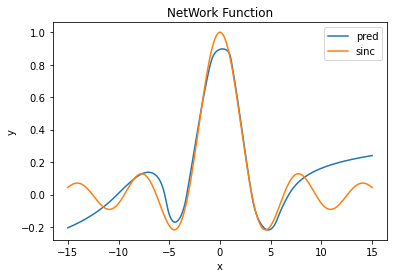

In [14]:
plt.plot(points.T, y_pred.T, label = 'pred')
plt.plot(points.T, sinc.T, label = 'sinc')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.title('NetWork Function')
plt.savefig('Assignment7_Question2_Plot5.pdf')
plt.show()